In [1]:
import torch
from torch.autograd import Variable
from jointangleenergy import JointAngleEnergy 
#import a pointnet somewhere as PointNet

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
sampler = JointAngleEnergy('saved/EBGAN/best.pth')

In [4]:
samples = sampler.generate_samples(10)


[0.59402794]


<IPython.core.display.Javascript object>


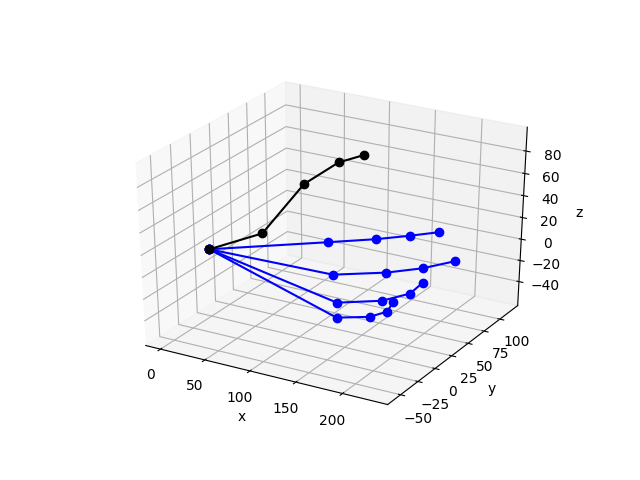

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import utils.hand as hand


sample = torch.FloatTensor(samples[0].reshape(1, -1))
sampler.discriminator.eval()
print(sampler.get_joint_angle_energy(sample))

#
# Make hand and update DOFs
#
start = np.array([[0., 0., 0.]]).T  
quat = np.array([0., 0., 0., 1.])

h = hand.makeHumanHand(start, quat)
h.updateDofs(sample.data.numpy().reshape(-1)) # don't forget to do this 
hand_pts = h.getJointPositions()
hand_pts = np.concatenate(hand_pts, axis=1).T


#############
# PLOT HAND #
#############

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hand_pts[0, 0], hand_pts[0, 1], hand_pts[0, 2], zdir='z', c= 'red', s=10)
# ax.scatter(pt_cld[:, 0], pt_cld[:, 1], pt_cld[:, 2], zdir='z', c= 'red', s=0.1)

# Axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax = ax.axis('equal')

# Draw hand
plt.plot(np.append(hand_pts[0, 0], hand_pts[1:5, 0]),   np.append(hand_pts[0, 1], hand_pts[1:5, 1]),   np.append(hand_pts[0, 2], hand_pts[1:5, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[5:9, 0]),   np.append(hand_pts[0, 1], hand_pts[5:9, 1]),   np.append(hand_pts[0, 2], hand_pts[5:9, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[9:13, 0]),  np.append(hand_pts[0, 1], hand_pts[9:13, 1]),  np.append(hand_pts[0, 2], hand_pts[9:13, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[13:17, 0]), np.append(hand_pts[0, 1], hand_pts[13:17, 1]), np.append(hand_pts[0, 2], hand_pts[13:17, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[17:21, 0]), np.append(hand_pts[0, 1], hand_pts[17:21, 1]), np.append(hand_pts[0, 2], hand_pts[17:21, 2]),'-o', c="black")

plt.show()

In [6]:
# generate random hand pose that looks like shit
# perturb perturb perturb

In [7]:
N_ITERS = 1000
SIGMA = 0.2
SAMPLES_PER_IT = 50
ALPHA = 0.01
N_THETAS = 10

In [4]:
from pointnet_datasets import *

mr = ModelReader()

batch = mr.getGraspBatch()

one_grasp = batch[1]
params = config(section='data')

scale, grasp_rescale, model_path = mr.getModelInfo(one_grasp["scaled_model_id"])

pt_cld = sample_pt_cld(scale, grasp_rescale, params['model_dir'] + model_path)

#classifier2 = PointNet2Seg(num_classes=20)
#load saved model
classifier2 = torch.load('train_model.pth')
classifier2 = classifier2.eval()

pointcloud = torch.tensor(pc_normalize(pt_cld)).unsqueeze(0).permute(0, 2, 1)
#pointclouds is a bs*3*n tensor (bs is batch_size so 1 for a particular mesh, n is the number of sampled points (10000 by default))

preds = classifier2(pointcloud).permute(0, 2, 1)
#preds is a bs*n*20 output (where it outputs the 'probability' of each sampled point (of 10k) being a contact point for any of the 20 joints)
#To use, just get the hand_pts from above (excluding root), find the closest point in pointclouds to each hand_pt (if it's within like 10 mm of points), and find the probability of those points being that respective joint (if less than 0.1, force it to be 0.1)
#If joint is more than 10mm from point cloud (not a contact joint) then just use default value as described in Shape2Pose paper

joints, probs = get_joint_probs(preds, pt_cld, hand_pts)
#print(probs)
#probs[probs < 0.1] = 0.1
print(joints, probs)

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

In [1]:
from scipy.linalg import norm
sampler.discriminator.eval()
thetas = []
for i in range(N_THETAS):
    theta = np.random.randn(1, 20)
    for t in range(N_ITERS):
        epsilons = np.random.randn(SAMPLES_PER_IT, 20)
        perturbations = theta + epsilons*SIGMA
        energies = sampler.get_joint_angle_energy(torch.from_numpy(perturbations))
        weighted_epsilons = np.einsum('i, ij -> ij', energies, epsilons)
        theta_update = ALPHA/(SAMPLES_PER_IT*SIGMA)*weighted_epsilons.sum(axis=0)
        theta -= theta_update
        #print(norm(theta_update))
    thetas.append(theta)
    #print(sampler.get_joint_angle_energy(torch.from_numpy(theta)))

NameError: name 'sampler' is not defined

<IPython.core.display.Javascript object>


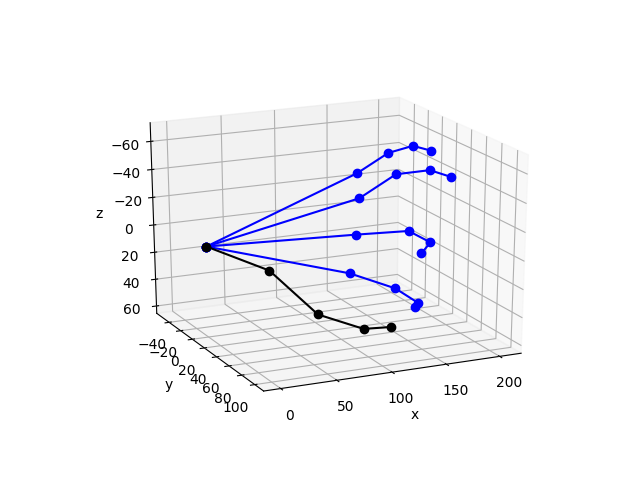

In [14]:
#
# Make hand and update DOFs
#
start = np.array([[0., 0., 0.]]).T  
quat = np.array([0., 0., 0., 1.])

h = hand.makeHumanHand(start, quat)
h.updateDofs(theta.reshape(-1)) # don't forget to do this 
hand_pts = h.getJointPositions()
hand_pts = np.concatenate(hand_pts, axis=1).T


#############
# PLOT HAND #
#############

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hand_pts[0, 0], hand_pts[0, 1], hand_pts[0, 2], zdir='z', c= 'red', s=10)
# ax.scatter(pt_cld[:, 0], pt_cld[:, 1], pt_cld[:, 2], zdir='z', c= 'red', s=0.1)

# Axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax = ax.axis('equal')

# Draw hand
plt.plot(np.append(hand_pts[0, 0], hand_pts[1:5, 0]),   np.append(hand_pts[0, 1], hand_pts[1:5, 1]),   np.append(hand_pts[0, 2], hand_pts[1:5, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[5:9, 0]),   np.append(hand_pts[0, 1], hand_pts[5:9, 1]),   np.append(hand_pts[0, 2], hand_pts[5:9, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[9:13, 0]),  np.append(hand_pts[0, 1], hand_pts[9:13, 1]),  np.append(hand_pts[0, 2], hand_pts[9:13, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[13:17, 0]), np.append(hand_pts[0, 1], hand_pts[13:17, 1]), np.append(hand_pts[0, 2], hand_pts[13:17, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[17:21, 0]), np.append(hand_pts[0, 1], hand_pts[17:21, 1]), np.append(hand_pts[0, 2], hand_pts[17:21, 2]),'-o', c="black")

plt.show()